### Machine learning for Systems & Control 5SC28 2022-2023

# Exercise Set Lecture 5: Deep Learning for S&C

In exercise Lecutre 5 you learn to use python and PyTorch for deep learning with an emphasis on system identification tasks.

## Table of contents

1. <a href="#Exercise-1:-Practical-Considerations-when-using-Deep-Neural-Networks">Exercise 1: Practical Considerations when using Deep Neural Networks</a>
2. <a href="#(Optional)-Exercise-2:-Choosing-Structure-Hyperparameters-in-Neural-Networks">(Optional) Exercise 2: Choosing Structure Hyperparameters in Neural Networks</a>
3. <a href="#Exercise-3:-Recurrent-Neural-Network-for-System-Identification">Exercise 3: Recurrent Neural Network for System Identification</a>
4. <a href="#(Demo)-Exercise-4:-Convolutional-Neural-Networks">(Demo) Exercise 4: Convolutional Neural Networks</a>

### Exercise 1: Practical Considerations when using Deep Neural Networks

 **a)** Create a neural network with 
  * 1 input and 1 output
  * 2 hidden layers 
  * 40 nodes (i.e neurons) per layer 
  * with sigmoid activation functions. (Excluding the last layer)

In [2]:
import torch
from torch import nn
from matplotlib import pyplot as plt 
import numpy as np

class Network(nn.Module):
    def __init__(self): #a)
        super(Network,self).__init__() #a)
        self.lay1 = nn.Linear(1,40) #a)
        self.lay2 = nn.Linear(40,40) #a)
        self.lay3 = nn.Linear(40,1) #a) 
    
    def forward(self,u): #a)
        u = u[:,None] #a)
        x1 = torch.sigmoid(self.lay1(u)) #a)
        x2 = torch.sigmoid(self.lay2(x1)) #a)
        y = self.lay3(x2)[:,0] #a)
        return y #a)


**b)** Fit this network on data given by `u_data` and `y_data` (`u_tensor`, `y_tensor` equivalent) with the `torch.optim.Adam` optimizer. (see: https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam for details)

As you might notice in exercise **b)** the fit is very slow and not accurate. This is because the input/output data is not normalized (mean zero, standard deviation of one, see first figure `u range [-0.004,0.004]` and `y range [0,4000]`). This results in vanishing gradients. 

**c)** Show the presence of vanishing gradients by appending the amplitude of the gradients (`.grad`) to a list for each training update and plot how it changes over time per layer.

*tip: `[torch.mean(par.grad**2).item()**0.5 for par in list(model.parameters())[::2]]` provides the amplitude of the gradients for each layer*

*tip: use the `.append` method of a newly created list to save the gradient amplitudes*

*tip: use plt.semilogy to plot on a logarithmic scale to improve the visualization*

One way to reduce the effect of vanishing gradients is normalization. Normalize the inputs and outputs to have a zero mean and a standard deviation of 1.

**d)** Apply a normalization step when defining `u_tensor` and `y_tensor` and observe the improvement in training time and gradient amplitudes. 

*tip: normalization can be achieved by using `(u_data-u_mean)/u_std`. Do not forget to denormalize the output while plotting by doing the inverse process (de-normalization)* 

There are currently two major advantages in using batched optimization. It is faster if the data set is large enough and it has shown to have regularization properties.

**e)** Implement batched optimization by introducing a second for loop (`for i in range(0,len(u_tensor)-batch_size,batch_size):`) and selecting a range of data as `u_tensor[i:i+batch_size]` with `batchsize=256`.

*tip: set batched to True*

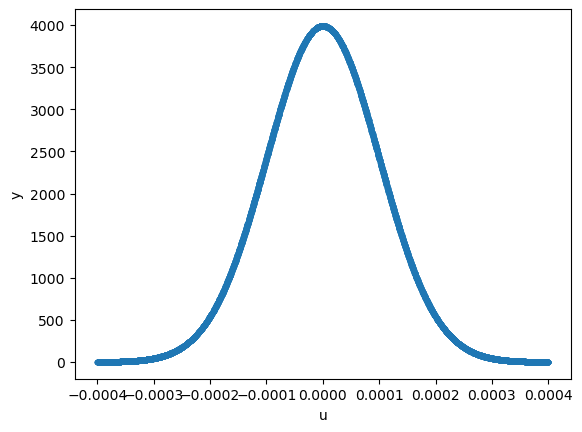

epoch=0/1000,NRMS=0.9405990706669558
438.2070085108321 updates per second (batch optimization)
epoch=100/1000,NRMS=0.0001290507504019462
631.4960832509182 updates per second (batch optimization)
epoch=200/1000,NRMS=8.373267653139053e-06
620.681738674219 updates per second (batch optimization)
epoch=300/1000,NRMS=3.051550639954934e-06
619.2219471755955 updates per second (batch optimization)
epoch=400/1000,NRMS=3.72524519901442e-06
620.7508526831712 updates per second (batch optimization)
epoch=500/1000,NRMS=2.7823861670791753e-06
622.2277987785787 updates per second (batch optimization)
epoch=600/1000,NRMS=6.070234237800919e-06
625.0953016733982 updates per second (batch optimization)
epoch=700/1000,NRMS=1.4317666396594902e-05
626.2414901299966 updates per second (batch optimization)
epoch=800/1000,NRMS=1.2428491970751084e-05
625.8479110124787 updates per second (batch optimization)
epoch=900/1000,NRMS=9.959565458258468e-06
627.1273453994902 updates per second (batch optimization)


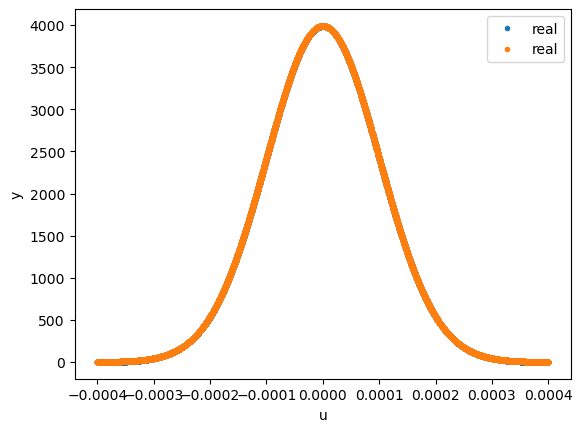

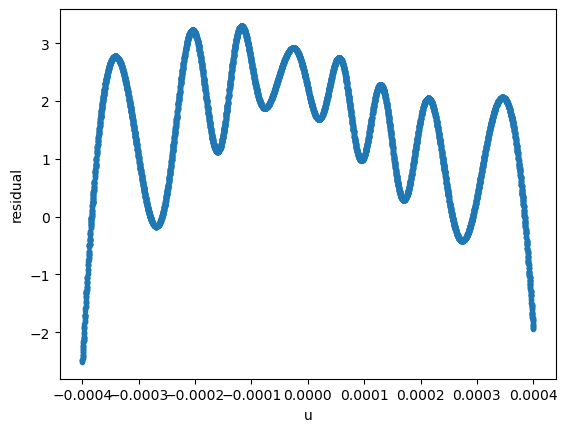

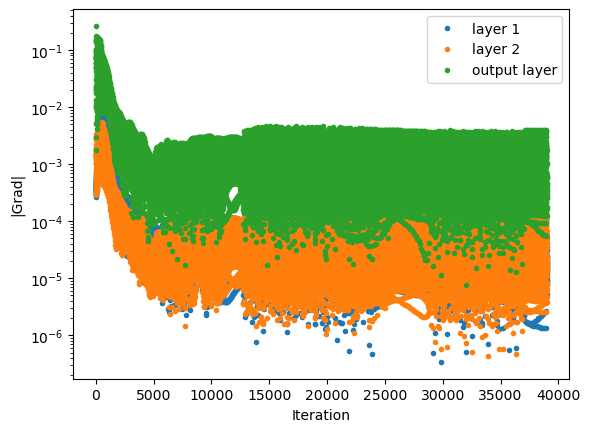

In [3]:
import numpy as np # array operations
from matplotlib import pyplot as plt # plotting

sigma_u = 0.0001 #small!
mu_u = 0
def Normal(u):
    y = 1/(sigma_u*np.sqrt(2*np.pi))*np.exp(-1/2*((u-mu_u)/sigma_u)**2) 
    return y

u_data = np.random.uniform(-4*sigma_u,4*sigma_u,size=10000)
y_data = Normal(u_data) 
plt.plot(u_data,y_data,'.') 
plt.xlabel('u')
plt.ylabel('y')
plt.show() 

model = Network() #b=)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) #b=) #see: https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam
u_tensor, y_tensor = torch.tensor(u_data, dtype=torch.float32), torch.tensor(y_data, dtype=torch.float32)
u_mean, u_std = np.mean(u_data), np.std(u_data) #d)
y_mean, y_std = np.mean(y_data), np.std(y_data) #d)
u_tensor = (u_tensor-u_mean)/u_std #d)
y_tensor = (y_tensor-y_mean)/y_std #d)

grads = [] #c)

import time
t_start = time.time() #current time in seconds
batched = False 
batch_size = 256 #e)
batched = True #e) 
epochs = 1000
for epoch in range(epochs):
    if batched: #used at e)
        dummy = 1 #this does nothing but prevent an error messege when for when e) is not yet solved
        for i in range(0,len(u_tensor)-batch_size,batch_size): #e)
            Loss = torch.mean((model(u_tensor[i:i+batch_size])-y_tensor[i:i+batch_size])**2) #e)
            optimizer.zero_grad() #e)
            Loss.backward() #e)
            optimizer.step() #e)
            grads.append([torch.mean(par.grad**2).item()**0.5 for par in list(model.parameters())[::2]]) #e)
    else: #use for b)
        Loss = torch.mean((model(u_tensor)-y_tensor)**2) #b)
        optimizer.zero_grad() #b)
        Loss.backward() #b)
        grads.append([torch.mean(par.grad**2).item()**0.5 for par in list(model.parameters())[::2]]) #c)
        optimizer.step() #b)
    if epoch%100==0: 
        print(f'epoch={epoch}/{epochs},NRMS={Loss.item()/torch.std(y_tensor).item()}')
        if batched:
            print(len(u_data)//batch_size*(epoch+1)/(time.time() - t_start),'updates per second (batch optimization)')
        else:
            print((epoch+1)/(time.time() - t_start),'updates per second (non-batch optimization)')


with torch.no_grad():
    y_predict = model(u_tensor)
    y_predict = model(u_tensor)*y_std+y_mean #d)
    plt.plot(u_data,y_predict,'.',label='real')
    plt.plot(u_data,y_data,'.',label='real')
    plt.xlabel('u')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    plt.plot(u_data,y_data-y_predict.numpy(),'.')
    plt.xlabel('u')
    plt.ylabel('residual')
    plt.show()    
    plt.semilogy(grads,'.') #c)
    plt.ylabel('|Grad|') #c)
    plt.xlabel('Iteration') #c)
    plt.legend(['layer 1', 'layer 2', 'output layer']) #c)
    plt.show() #c)

### (Optional) Exercise 2: Choosing Structure Hyperparameters in Neural Networks

Most rules for choosing neural network structure parameters such as depth, activation function, and layer width are vague: e.g. "for more complex problems you need to increase the depth and width" and hence typically do not provide quantativative guidance. 

In deep learning the most common approach of resolving this is: 

1. Look up what others have used on similare problems and use that as a starting point.
2. Do a hyperparameter search using cross validaton around that starting point.

This hyperparameter search is often implemented as:

* Manual search
* Random search (do multiple samples at the same time)
* Grid search method
  * Partial grid search (Check each direction seperatly, i.e. local search)
  * Exhaustive grid search (visit each point at least ones)
* Byasian optimization methods

Below you can find that an example has been set up, where `X_train`, `X_val` is the data provided. (see plot) Also a simple fully connected neural network `Simple_net` where `n_hidden_layer, n_nodes_per_layer, activation` are provided as `__init__` arguments, and finally, a `fit` function which can fit this network to the data is provided as well. 

**a)** Now it's up to you to write the `test` function which, (i) creates the network, (ii) uses the `fit` function to fit the network and, (iii) computes the RMS error on the validation set and (iv) return a python floating point number.

*tip: use .item() to convert to a float*

*note: I added `lru_cache` to the function such that it will cache any result to speed up optimization.*



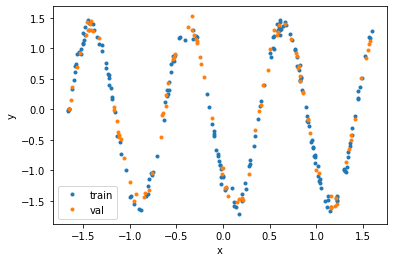

In [3]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np

#make data
torch.random.manual_seed(232)
X_train = torch.rand(300)*20 #float32
Y_train = torch.sin(X_train) + torch.randn(X_train.shape[0])*0.05

#split in train and validation (You can also use multifold cross validation)
X_train, X_val = X_train[:200], X_train[200:]
Y_train, Y_val = Y_train[:200], Y_train[200:]

#normalize data
ymean, ystd = Y_train.mean().item(), Y_train.std().item()
xmean, xstd = X_train.mean().item(), X_train.std().item()

Y_train = (Y_train - ymean)/ystd
X_train = (X_train - xmean)/xstd
Y_val = (Y_val - ymean)/ystd
X_val = (X_val - xmean)/xstd


plt.plot(X_train.numpy(), Y_train.numpy(),'.')
plt.plot(X_val.numpy(), Y_val.numpy(),'.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['train','val'])
plt.show()

import functools

class Simple_net(nn.Module):
    def __init__(self, n_hidden_layer, n_nodes_per_layer, activation):
        super().__init__()
        
        if n_hidden_layer==0: #linear model
            seq = [nn.Linear(1,1)]
        else:
            seq = [nn.Linear(1,n_nodes_per_layer), activation()]
            for layer in range(n_hidden_layer-1):
                seq.extend([nn.Linear(n_nodes_per_layer,n_nodes_per_layer), activation()])
            seq.append(nn.Linear(n_nodes_per_layer,1))
        
        self.non_lin_net = nn.Sequential(*seq)
    
    def forward(self, x):
        return self.non_lin_net(x[:,None])[:,0]
    
def fit(net, X_data, Y_data, X_val, Y_val, epochs=5*10**3):
    optimizer = torch.optim.Adam(net.parameters())
    best_state = None
    best_loss = float('inf')
    
    for epoch in range(1,epochs+1):
        loss = torch.mean((net(X_data)-Y_data)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%1000==0:
            loss_val = torch.mean((net(X_val)-Y_val)**2).item()**0.5 #RMS
            if loss_val<best_loss:
                from copy import deepcopy
                best_state = deepcopy(net.state_dict())
                best_loss = loss_val
            print(f'epoch={epoch:5}, loss={loss.item()**0.5:.2f}')
    if best_state:
        net.load_state_dict(best_state)
    return net

import functools
@functools.cache(maxsize=500, typed=False)
def test(X_train, Y_train, X_val, Y_val, n_hidden_layer=2, n_nodes_per_layer=20, activation=nn.Tanh):
    net = Simple_net(n_hidden_layer, n_nodes_per_layer, activation) #a=)
    net = fit(net, X_train, Y_train, X_val, Y_val) #a=)
    RMS = torch.mean((net(X_val)-Y_val)**2).item()**0.5 #a=)
    return RMS #a=)
    

Below you can find a local grid search method which varies each direction (i.e. structure parameter) over the given range in `choices_dict` and puts the result in `current_best` if a new lowest `test` has been obtained. 

**b)** Run the optimization below and observe the results. 

**c)** Why might this optimization strategy not be optimal?

**Answer c):** First off, the grid given in `choices_dict` might not be wide enough (user need to widen the search if needed). Secondly, the optimization can get stuck in local minima as it is a local search method. However, in deep learning it is often observed that this strategy still finds good structures even with these two drawbacks. 

In [4]:
#a basic optimizer 
current_best = dict(n_hidden_layer=3, n_nodes_per_layer=5, activation=nn.Sigmoid)
choices_dict = dict(n_hidden_layer=[1,2,3,4], \
               n_nodes_per_layer=[5,10,20,50,100], \
               activation=[nn.Tanh,nn.ReLU,nn.ELU,nn.Sigmoid])

import copy
for it in range(30):
    last_best = copy.deepcopy(current_best)
    
    for name, choices in choices_dict.items(): #iterate over the n_hidden_layer, n_nodes_per_layer, activation
        results = []
        for choice in choices: #check each candidate
            now = copy.deepcopy(current_best) #create a new dict
            now[name] = choice #put choice in the correct place
            print('optimizing...',now) 
            results.append(test(X_train, Y_train, X_val, Y_val,**now)) #add it to results

        print('done with loop for option', name)
        print('\n'.join([f'choice={c} result={r:.5}' for c,r in zip(choices,results)]))
        pick = choices[np.argmin(results)]
        print(f'picking = {pick} {name}')
        current_best[name] = pick
    
    if last_best==current_best:
        print('no change deteched, optimization complete')
        print(f'completed with {current_best}')
        break

optimizing... {'n_hidden_layer': 1, 'n_nodes_per_layer': 5, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}
epoch= 1000, loss=0.96
epoch= 2000, loss=0.95
epoch= 3000, loss=0.94
epoch= 4000, loss=0.94
epoch= 5000, loss=0.93
optimizing... {'n_hidden_layer': 2, 'n_nodes_per_layer': 5, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}
epoch= 1000, loss=0.96
epoch= 2000, loss=0.94
epoch= 3000, loss=0.91
epoch= 4000, loss=0.87
epoch= 5000, loss=0.82
optimizing... {'n_hidden_layer': 3, 'n_nodes_per_layer': 5, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}
epoch= 1000, loss=0.96
epoch= 2000, loss=0.93
epoch= 3000, loss=0.92
epoch= 4000, loss=0.91
epoch= 5000, loss=0.89
optimizing... {'n_hidden_layer': 4, 'n_nodes_per_layer': 5, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>}
epoch= 1000, loss=0.99
epoch= 2000, loss=0.92
epoch= 3000, loss=0.91
epoch= 4000, loss=0.91
epoch= 5000, loss=0.91
done with loop for option n_hidden_layer
choice=1 result

### Exercise 3: Recurrent Neural Network for System Identification

One of the main methods to process time series in deep learning is through Recurrent Neural Networks (RNN). There are many different kinds of RNN however, we will show only the simple RNN that can be seen below. This structure is related to state-space modelling and non-linear output error (NOE) modelling.

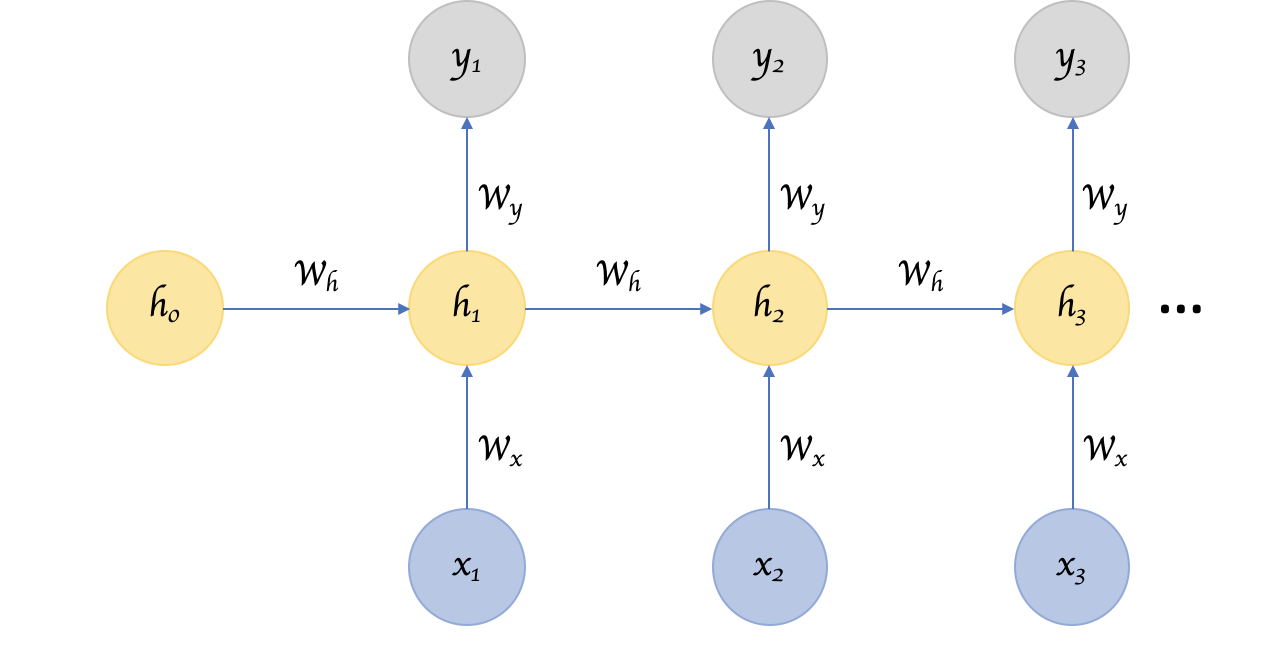

This recursive neural network can be broken down into two functions. 

 * Function 1: advance the hidden state given some input `h2h`
 
 $$ h_{k+1} = \text{h2h}(h_{k},u_{k}) $$
 
 * Function 2: hidden state (and input) to output `h2o`
 
 $$ y_{k} = \text{h2o}(h_{k},u_{k}) $$
 
These functions can be linear or non-linear. 

We will consider the following system: 

$$y_k = (0.8-0.5 \exp(-y_{k-1}^2)) y_{k-1} - (0.3 + 0.9 \exp(y_{k-1}) y_{k-2} + u_{k-1} + 0.2 u_{k-2} + 0.1 u_{k-1} u_{k-2}$$

$$u_k \sim \text{Uniform}[-2,2]$$

and normalization on both $u$ and $y$. 

**Run the following cell to generate the data (no modification required):** This will generate `utrain` `ytrain` `uval` `yval` to train and validate on.


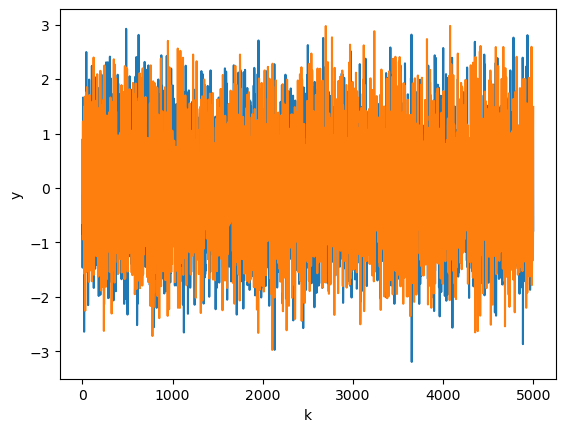

In [10]:
#run this code block
import numpy as np
from matplotlib import pyplot as plt
import copy

def h2h0(x,u):
    uhist,yhist = x
    y = h2o0(x,u)
    uhist.append(u)
    yhist.append(y)
    return uhist[1:],yhist[1:]
def h2o0(x,u):
    (ukm2,ukm1),(ykm2,ykm1) = x
    uk = u
    yk = (0.8 - 0.5 * np.exp(-ykm1 ** 2)) * ykm1 - (0.3 + 0.9 * np.exp(-ykm1 ** 2)) * ykm2 \
               + ukm1 + 0.2 * ukm2 + 0.1 * ukm1 * ukm2 
    return yk #+ np.random.normal(scale=0.4) #current u does not influence current y
def reset():
    return ([0,0],[0,0])
def apply_experiment(ulist,h2h,h2o,x0):
    if callable(x0):
        x = x0()
    else:
        x = copy.deepcopy(x0)
    ylist = [] #creates an empty list (1D object) which later can be extended by the .append method
    for u in ulist: #itterates over the elements of ulist
        ylist.append(h2o(x,u))
        x = h2h(x,u)
    return np.array(ylist) #convert list to array for easier processing

U_A = 2
utrain = np.random.uniform(low=-U_A,high=U_A,size=(5000,))
ytrain = apply_experiment(utrain,h2h=h2h0,h2o=h2o0,x0=reset)
uval = np.random.uniform(low=-U_A,high=U_A,size=(5000,))
yval = apply_experiment(uval,h2h=h2h0,h2o=h2o0,x0=reset)
u_mean, u_std = np.mean(utrain),np.std(utrain)
y_mean, y_std = np.mean(ytrain),np.std(ytrain)


### Data to train and validate on ###:
utrain = (utrain-u_mean)/u_std #normalize
ytrain = (ytrain-y_mean)/y_std 

uval = (uval-u_mean)/u_std
yval = (yval-y_mean)/y_std

plt.plot(ytrain)
plt.plot(yval)
plt.xlabel('k')
plt.ylabel('y')
plt.show()

Batched optimization is very useful when using very long time series when training a recurrent neural network. This can be achieved in this case by utilizing sub-sequences. The sub-sequences are denoted by:

$$U_k = \{u_{k-n_f},u_{k-n_f+1},...,u_{k-1}\}$$
 
$$Y_k = \{y_{k-n_f},y_{k-n_f+1},...,y_{k-1}\}$$

**a)** Write a function which takes a time series for both $u$ and $y$ and extract every possible sub-sequence ($U_k,Y_k$) of length `nf` for every possible $k$.

In [15]:
import torch

def make_OE_data(udata, ydata, nf=100):
    U = [] 
    Y = [] 
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k]) #a)
        Y.append(ydata[k-nf:k]) #a)
    return np.array(U), np.array(Y)

nfuture = 30
convert = lambda x: [torch.tensor(xi, dtype=torch.float32) for xi in x]
Utrain, Ytrain = convert(make_OE_data(utrain, ytrain, nf=nfuture))
Uval,   Yval   = convert(make_OE_data(uval,   yval,   nf=len(uval))) #uses the whole data set for OE

**b)** Write a simple RNN with 1 input and 1 ouput with `self.h2h` to indicate the hidden to hidden function and `self.h2o` to indicate the hidden to output function. Make both functions an ANN with a single hidden layer with 40 hidden nodes with Sigmoid activation. `hidden_size` indicates the number of elements in hidden state. 

*tip: take special care when defining the input and output size of both functions* 

**c)** Write the forward function which takes in a batched time series of inputs (i.e. `(N_batch,N_time)`) and returns the predicted output in shape `(N_batch,N_time)`. 

*tip 1: initialize the hidden layer with a tensor of zeros with `torch.zeros` (use dtype=torch.float32 key word argument)*

*tip 2: iterate over the second dimension of the input and concatenate with the hidden layer to get the input for both `h2o` and `h2h` (see `torch.cat`),*

*tip 3: collect outputs by setting `outputs = []`, using `outputs.append` to add data and `torch.stack` to convert it back to a tensor.*

In [16]:
import torch
from torch import nn

class simple_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(simple_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40), \
                                               nn.Sigmoid(), \
                                               nn.Linear(40,n_out)) #new short hand
        self.h2h = net(self.input_size + hidden_size, self.hidden_size) #b=)
        self.h2o = net(self.input_size + hidden_size, self.output_size) #b=)
                                                                        #[:,0] should be called after use of h2o

    def forward(self, inputs):
        #input.shape == (N_batch, N_time)
        hidden = torch.zeros(inputs.shape[0], self.hidden_size, dtype=torch.float32) #c)
        outputs = [] #c)
        for i in range(inputs.shape[1]): #c)
            u = inputs[:,i] #shape = (N_batch,) #c)
            combined = torch.cat((hidden, u[:,None]), dim=1) #c) #shape = (N_batch,hidden_size+1)
            outputs.append(self.h2o(combined)[:,0]) #c)
            hidden = self.h2h(combined) #c)
        return torch.stack(outputs,dim=1) #c)

**d)** Create the RNN you wrote and train this network using the `torch.optim.Adam` optimizer (see: https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and batched optimization. The loss function is the MSE loss which skips the first `n_burn=10` steps to skip the initial transient and use `hidden_size=15`.


In [17]:

n_burn = 10
batch_size = 64

model = simple_RNN(hidden_size=15) #d=)
optimizer = torch.optim.Adam(model.parameters()) #d=)


ids = np.arange(len(Utrain),dtype=int) 
for epoch in range(50):
    np.random.shuffle(ids) #inspace shuffle of the ids of the trainin set to select a random subset 
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size] #the ids of the current batch
        Uin = Utrain[ids_now] #d)
        Y_real = Ytrain[ids_now] #d)

        Y_predict = model.forward(inputs=Uin) #d)
        residual = Y_real - Y_predict #d)
        Loss = torch.mean(residual[:,n_burn:]**2) #d)
        
        optimizer.zero_grad()  #d)
        Loss.backward()  #d)
        optimizer.step()  #d)
    
    with torch.no_grad(): #monitor
        Loss_val = torch.mean((model(inputs=Uval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation NRMS={Loss_val.item():.2%}, Train NRMS={Loss_train.item():.2%}')

epoch=0, Validation NRMS=91.74%, Train NRMS=91.22%
epoch=1, Validation NRMS=47.89%, Train NRMS=47.88%
epoch=2, Validation NRMS=34.67%, Train NRMS=33.72%
epoch=3, Validation NRMS=34.46%, Train NRMS=33.38%
epoch=4, Validation NRMS=33.34%, Train NRMS=32.50%
epoch=5, Validation NRMS=32.65%, Train NRMS=31.72%
epoch=6, Validation NRMS=31.26%, Train NRMS=30.64%
epoch=7, Validation NRMS=30.20%, Train NRMS=29.48%
epoch=8, Validation NRMS=29.55%, Train NRMS=28.91%
epoch=9, Validation NRMS=29.15%, Train NRMS=28.58%
epoch=10, Validation NRMS=28.95%, Train NRMS=28.27%
epoch=11, Validation NRMS=28.70%, Train NRMS=28.34%
epoch=12, Validation NRMS=28.72%, Train NRMS=28.08%
epoch=13, Validation NRMS=28.39%, Train NRMS=27.69%
epoch=14, Validation NRMS=28.15%, Train NRMS=27.50%
epoch=15, Validation NRMS=27.86%, Train NRMS=27.27%
epoch=16, Validation NRMS=27.74%, Train NRMS=27.10%
epoch=17, Validation NRMS=27.40%, Train NRMS=26.88%
epoch=18, Validation NRMS=27.33%, Train NRMS=26.72%
epoch=19, Validation N

Visualization of results **run this block**

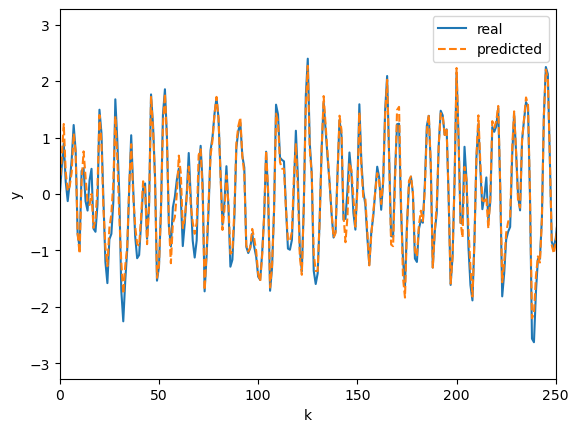

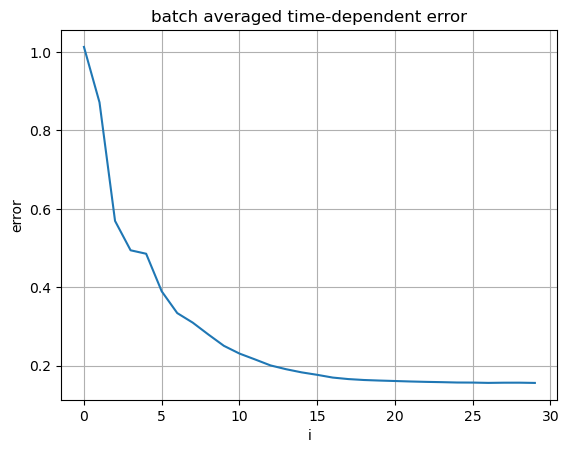

In [18]:
with torch.no_grad():
    plt.plot(Yval[0])
    plt.plot(model(inputs=Uval)[0],'--')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    plt.plot(np.mean((Ytrain-model(inputs=Utrain)).numpy()**2,axis=0)**0.5) #average over the error in batch
    plt.title('batch averaged time-dependent error')
    plt.ylabel('error')
    plt.xlabel('i')
    plt.grid()
    plt.show()

**e)** Why does the batch averaged time-dependent error defined by (and shown in the figure above)

$$ error_i = \sqrt{\frac{1}{N} \sum_{k} |\hat y_{k \rightarrow k+i}-y_{k+i}|^2} $$

and by the code `np.mean((Ytrain-model(inputs=Utrain)).numpy()**2,axis=0)**0.5` starts at $\text{error}_0 \approx 1$ and goes down to a a constant value. 

*tip: do not forget the normalization which was applied*

*tip 2: What happens if the model only predicts the average `y`?*

**Answer e):** In the initial step where $\hat y_i= \text{h2o}(0,u_i) = \text{h2o}(0)$ ($u_i$ in this system does not influence the current output) the lowest MSE in the initial state is when $\hat y_i$ is equal to the average $y$. Thus the equation for $\text{error}_0$ will read as standard deviation which is known to be 1 due to the normalization. When $i$ is large the equation will be that of the output error equation which typically converges to a constant value which depends on the model quality. This also motivates the use of a burn-in time to remove the initial transient effects. 

## Encoders

The burn-in time / transient can be quite long. Encoders offer an alternative to find the initial state using a part of the past outputs and inputs: 

$$
 \text{inital state} \approx e_\theta(u_{past}, y_{past})$$ 
 $$
 = e_\theta(u_{k-n_f-n_e},...,u_{k-n_f-1},y_{k-n_f-n_e},...,y_{k-n_f-1})
$$

**f)**  Rewrite the subsequence extractor to also include `n_encode` of the history for both `u` and `y` (*tip: concatenate the `udata[k-nf-n_encode:k-nf]` and `ydata[k-nf-n_encode:k-nf]` using `np.concatenate` and change the range of `k`*)

$$U_k = \{u_{k-n_f},u_{k-n_f+1},...,u_{k-1}\}$$
 
$$Y_k = \{y_{k-n_f},y_{k-n_f+1},...,y_{k-1}\}$$

$$\text{hist}_k = \{u_{k-n_f-n_e},...,u_{k-n_f-1},y_{k-n_f-n_e},...,y_{k-n_f-1}\} $$

In [19]:
def make_OE_init_state_data(udata, ydata, nf=100, n_encode=20):
    U = [] 
    Y = [] 
    hist = [] 
    for k in range(nf+n_encode,len(udata)+1):
        hist.append(np.concatenate((udata[k-nf-n_encode:k-nf], ydata[k-nf-n_encode:k-nf]))) #f)
        U.append(udata[k-nf:k]) #f)
        Y.append(ydata[k-nf:k]) #f)
    return np.array(hist), np.array(U), np.array(Y)

nfuture = 35
n_encode = 20
convert = lambda x: [torch.tensor(xi, dtype=torch.float32) for xi in x]
histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(utrain, ytrain, nf=nfuture,            n_encode=n_encode))
histval,   Uval,   Yval   = convert(make_OE_init_state_data(uval,   yval,   nf=len(uval)-n_encode, n_encode=n_encode))

**g)** Modify the simple RNN from **b)** to not initialize the hidden states using zeros but with an encoder.

In [23]:
class simple_encoder_RNN(nn.Module):
    def __init__(self, hidden_size, n_encoder=20):
        super(simple_encoder_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40),nn.Sigmoid(),nn.Linear(40,n_out)) #short hand for a 1 hidden layer NN
        self.h2h = net(self.input_size + hidden_size, self.hidden_size)
        self.h2o = net(self.input_size + hidden_size, self.output_size)
        self.encoder = net(n_encoder*2,hidden_size) #g=)

    def forward(self,inputs,hist):
        hidden = self.encoder(hist) #g=)
        outputs = []
        for i in range(inputs.shape[1]):
            input = inputs[:,i]
            combined = torch.cat((hidden, input[:,None]), 1)
            outputs.append(self.h2o(combined)[:,0])
            hidden = self.h2h(combined)
        return torch.stack(outputs,dim=1)

**h)** Fit the encoder RNN and show the results.

In [24]:
model = simple_encoder_RNN(hidden_size=15,n_encoder=n_encode) #h=)
optimizer = torch.optim.Adam(model.parameters())#h=)
batch_size = 64

ids = np.arange(len(Utrain),dtype=int)
for epoch in range(50):
    np.random.shuffle(ids)
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size]
        Uin = Utrain[ids_now]
        histin = histtrain[ids_now]
        Y_real = Ytrain[ids_now]

        Y_predict = model.forward(inputs=Uin,hist=histin) #h=)
        residual = Y_real - Y_predict 
        Loss = torch.mean(residual**2) #no burn time
        
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        Loss_val = torch.mean((model(inputs=Uval,hist=histval) - Yval)**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain,hist=histtrain) - Ytrain)**2)**0.5
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():.2%}, Train Loss={Loss_train.item():.2%}')

epoch=0, Validation Loss=76.18%, Train Loss=75.83%
epoch=1, Validation Loss=36.58%, Train Loss=35.70%
epoch=2, Validation Loss=34.32%, Train Loss=33.03%
epoch=3, Validation Loss=34.03%, Train Loss=32.71%
epoch=4, Validation Loss=33.34%, Train Loss=32.16%
epoch=5, Validation Loss=32.74%, Train Loss=31.58%
epoch=6, Validation Loss=31.66%, Train Loss=30.66%
epoch=7, Validation Loss=30.85%, Train Loss=29.92%
epoch=8, Validation Loss=30.12%, Train Loss=29.13%
epoch=9, Validation Loss=29.56%, Train Loss=28.74%
epoch=10, Validation Loss=29.11%, Train Loss=28.25%
epoch=11, Validation Loss=29.13%, Train Loss=28.07%
epoch=12, Validation Loss=28.53%, Train Loss=27.61%
epoch=13, Validation Loss=27.95%, Train Loss=27.14%
epoch=14, Validation Loss=27.63%, Train Loss=26.83%
epoch=15, Validation Loss=26.85%, Train Loss=26.03%
epoch=16, Validation Loss=26.25%, Train Loss=25.36%
epoch=17, Validation Loss=25.42%, Train Loss=24.57%
epoch=18, Validation Loss=24.21%, Train Loss=23.36%
epoch=19, Validation L

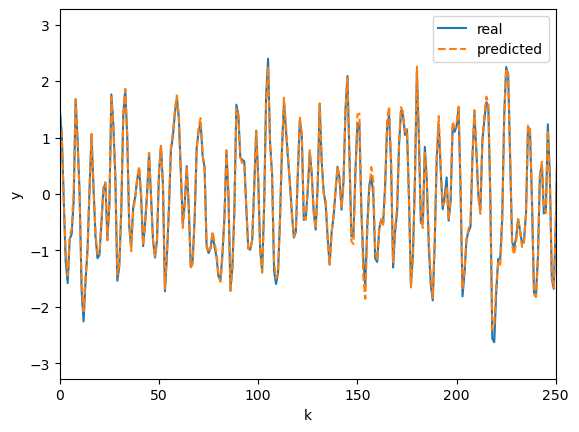

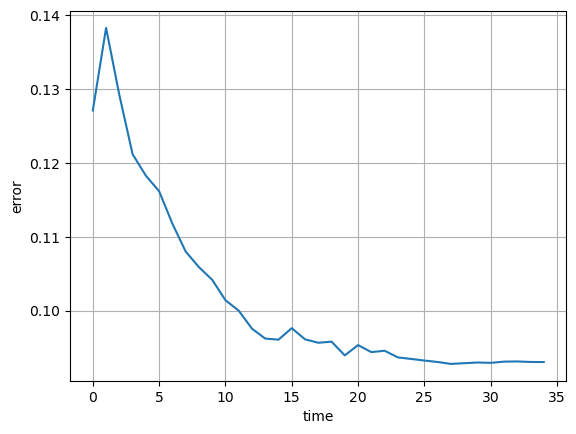

In [25]:
with torch.no_grad():
    plt.plot(Yval[0])
    plt.plot(model(inputs=Uval,hist=histval)[0],'--')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    plt.plot(np.mean((Ytrain-model(inputs=Utrain,hist=histtrain)).numpy()**2,axis=0)**0.5)
    plt.ylabel('error')
    plt.xlabel('time')
    plt.grid()
    plt.show()


Observe that the batched average error does not start at 1 but at a much lower value due to the encoder, the burn in / transient error has been reduced. 

## LSTM

It has been observed that regular RNN have difficulty to capture long-term time dependencies. An alternative which largely resolves this problem is the Long Short-Term Memory (LSTM) architecture which has a built-in gated memory component of `c_t`

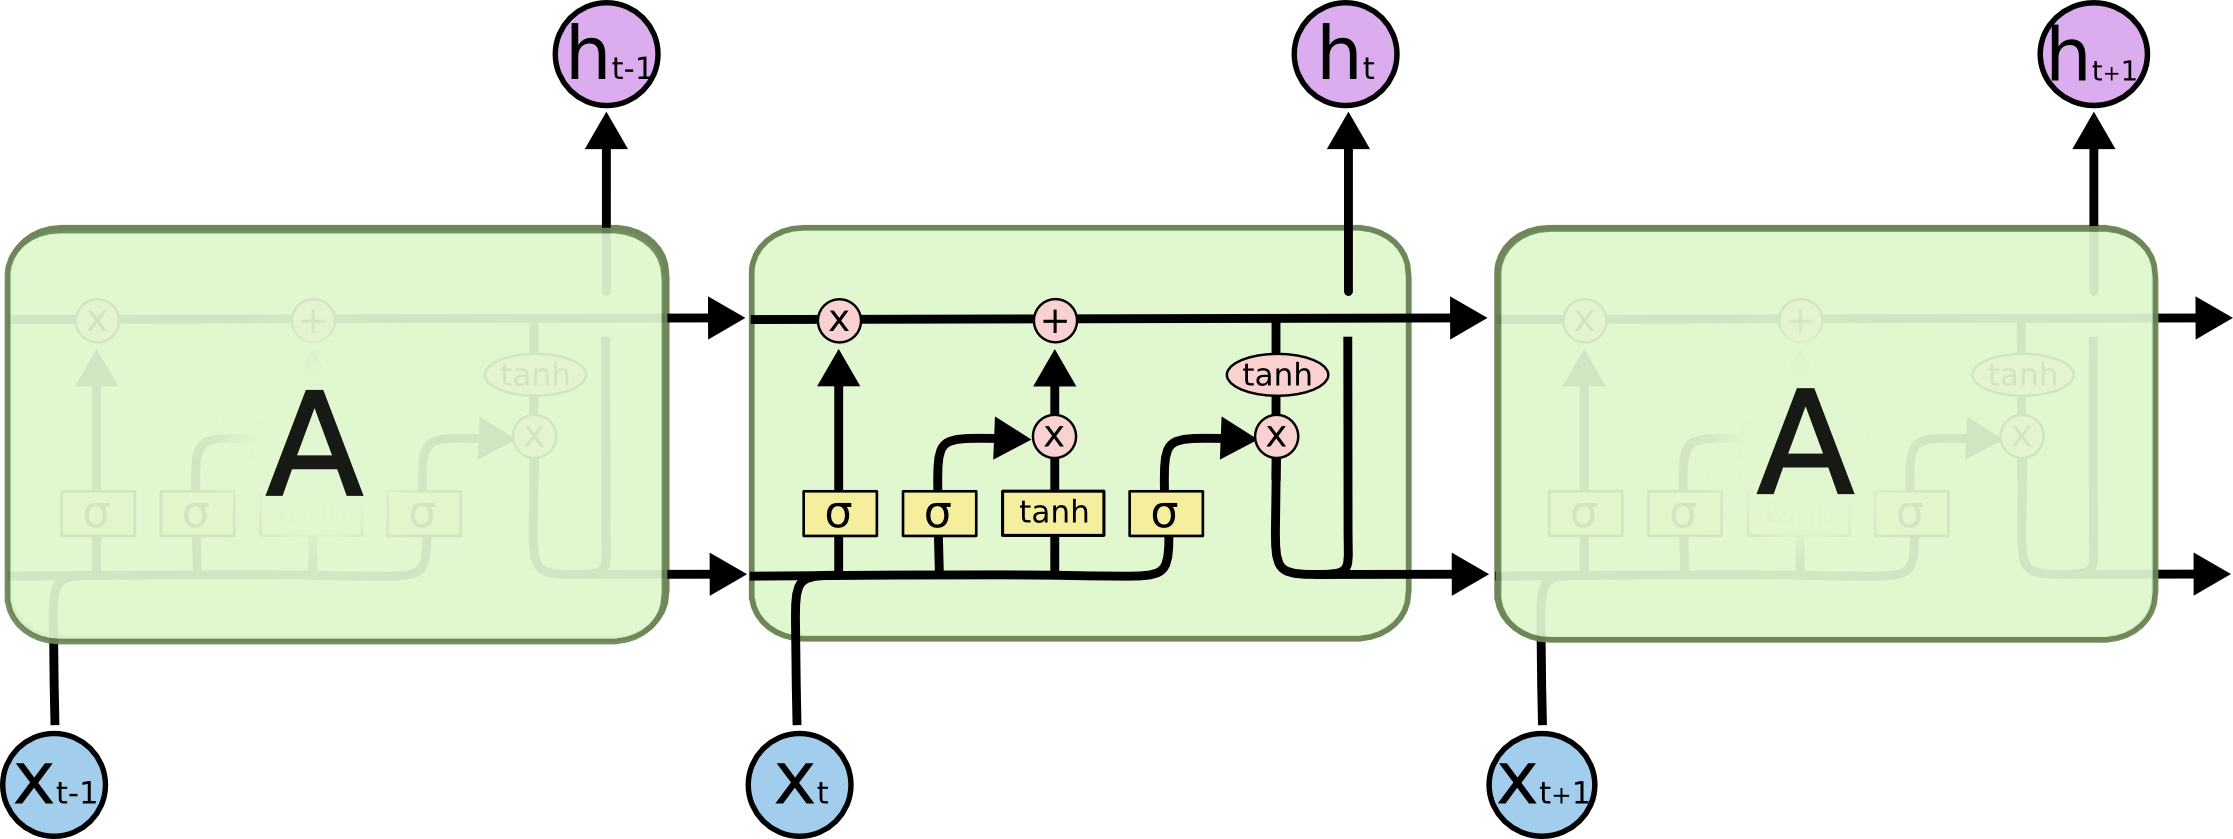

See for a detailed explanation of LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

 **i)** Use the built-in `nn.LSTM` neural network structure in PyTorch to estimate the dynamics of the system. Don't use the encoder structure for this.
 *tip: set `batch_first=True` in `nn.LSTM` (see: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)*
 

In [26]:
def make_OE_data(udata,ydata,nf=100):
    U = [] #[u[k-nf],...,u[k]]
    Y = [] #[y[k-nf],...,y[k]]
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k])
        Y.append(ydata[k-nf:k])
    return np.array(U),np.array(Y)

nfuture = 40
convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
Utrain,Ytrain = convert(make_OE_data(utrain,ytrain,nf=nfuture))
Uval,Yval = convert(make_OE_data(uval,yval,nf=len(uval)))

class simple_lstm(nn.Module):
    def __init__(self, hidden_size):
        super(simple_lstm, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40),nn.Sigmoid(),nn.Linear(40,n_out)) #short hand for a 1 hidden layer NN
        self.lstm = nn.LSTM(input_size=self.input_size,  hidden_size=hidden_size,  batch_first=True) #i)
        self.h2o = net(hidden_size + self.input_size, self.output_size) #i)

    def forward(self, inputs):
        hiddens, (h_n, c_n) = self.lstm(inputs[:,:,None]) #i)
        combined = torch.cat((hiddens,inputs[:,:,None]),dim=2) #i)
        if False: #two ways to solve this #i)
            y_predict = [] #i)
            for i in range(combined.shape[1]):  #i)
                y_predict.append(self.h2o(combined[:,i,:])[:,0])  #i)
            y_predict = torch.stack(y_predict,dim=1)  #i)
        else: #this is faster but more complex #i)
            #reshape from (N_batch, N_time, N_hidden) to (N_batch*N_time, N_hidden) #i)
            h2o_input = combined.view(-1,self.hidden_size+self.input_size) #i)
            #apply and reshape from (N_batch*N_time,1) to (N_batch,N_time) #i)
            y_predict =  self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])  #new #i)
        
        return y_predict

n_burn = 20
model = simple_lstm(hidden_size=15)
optimizer = torch.optim.Adam(model.parameters())
batch_size = 64

for epoch in range(50):
    for i in range(0,len(Utrain),batch_size):
        Uin = Utrain[i:i+batch_size]
        Yout = model.forward(inputs=Uin)
        Yin = Ytrain[i:i+batch_size]
        Loss = torch.mean((Yin[:,n_burn:] - Yout[:,n_burn:])**2)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        Loss_val = torch.mean((model(inputs=Uval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():.2%}, Train Loss={Loss_train.item():.2%}')

epoch=0, Validation Loss=94.96%, Train Loss=94.39%
epoch=1, Validation Loss=60.32%, Train Loss=59.73%
epoch=2, Validation Loss=37.54%, Train Loss=36.17%
epoch=3, Validation Loss=34.97%, Train Loss=33.73%
epoch=4, Validation Loss=33.44%, Train Loss=32.32%
epoch=5, Validation Loss=32.36%, Train Loss=31.31%
epoch=6, Validation Loss=31.52%, Train Loss=30.51%
epoch=7, Validation Loss=30.82%, Train Loss=29.83%
epoch=8, Validation Loss=30.25%, Train Loss=29.27%
epoch=9, Validation Loss=29.77%, Train Loss=28.78%
epoch=10, Validation Loss=29.36%, Train Loss=28.35%
epoch=11, Validation Loss=29.00%, Train Loss=27.97%
epoch=12, Validation Loss=28.68%, Train Loss=27.63%
epoch=13, Validation Loss=28.40%, Train Loss=27.32%
epoch=14, Validation Loss=28.13%, Train Loss=27.03%
epoch=15, Validation Loss=27.87%, Train Loss=26.76%
epoch=16, Validation Loss=27.62%, Train Loss=26.49%
epoch=17, Validation Loss=27.38%, Train Loss=26.24%
epoch=18, Validation Loss=27.14%, Train Loss=25.99%
epoch=19, Validation L

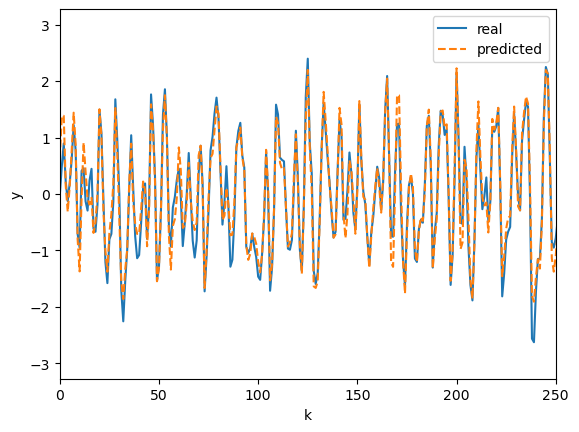

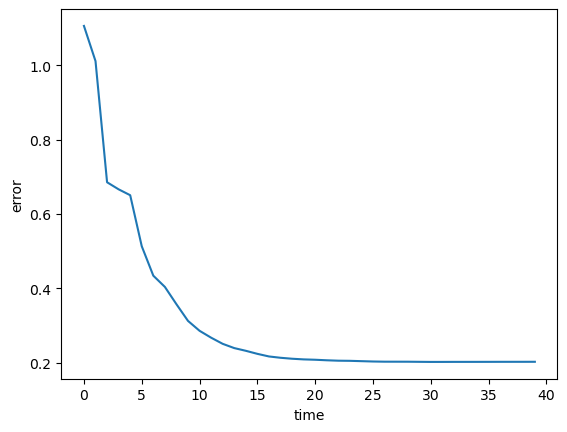

In [27]:
with torch.no_grad():
    plt.plot(Yval[0])
    plt.plot(model(inputs=Uval)[0],'--')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    plt.plot(np.mean((Ytrain-model(inputs=Utrain)).numpy()**2,axis=0)**0.5)
    plt.ylabel('error')
    plt.xlabel('time')
    plt.show()


Note that the LSTM network performs worse than the RNN used earlier. The example system does not have long-term memory effects. Hence, this is not a very good example to illustrate the LSTM capabilities. 

##  (Demo) Exercise 4: Convolutional Neural Networks

*tip: don't run these block, they might take a while to complete*

One of the most elegent real-life applications of convolutional neural networks is image super resolution which will be addressed in this exercise. 

Image super resolution is the problem of upscaling images as if they were captured with a higher resolution camera. You will implement this in the following way. 

0. Obtaining data
1. Preparing the data
2. Obtain baseline models (e.g. bi-linear interpolation)
3. Training our CNN approach on it
4. Plot Results

### Step 0: Obtaining the data 

For super resolution we only require a few examples. The next block will download 8 images of butterflies. 

initial size img.size=(3144, 2082)
after resize img.size=(1000, 662)
initial size img.size=(1200, 900)
after resize img.size=(1000, 750)
initial size img.size=(1280, 720)
after resize img.size=(1000, 562)
initial size img.size=(669, 446)
after resize img.size=(669, 446)
initial size img.size=(1024, 576)
after resize img.size=(1000, 562)
initial size img.size=(1245, 700)
after resize img.size=(1000, 562)
initial size img.size=(800, 500)
after resize img.size=(800, 500)
initial size img.size=(2399, 1855)
after resize img.size=(1000, 773)


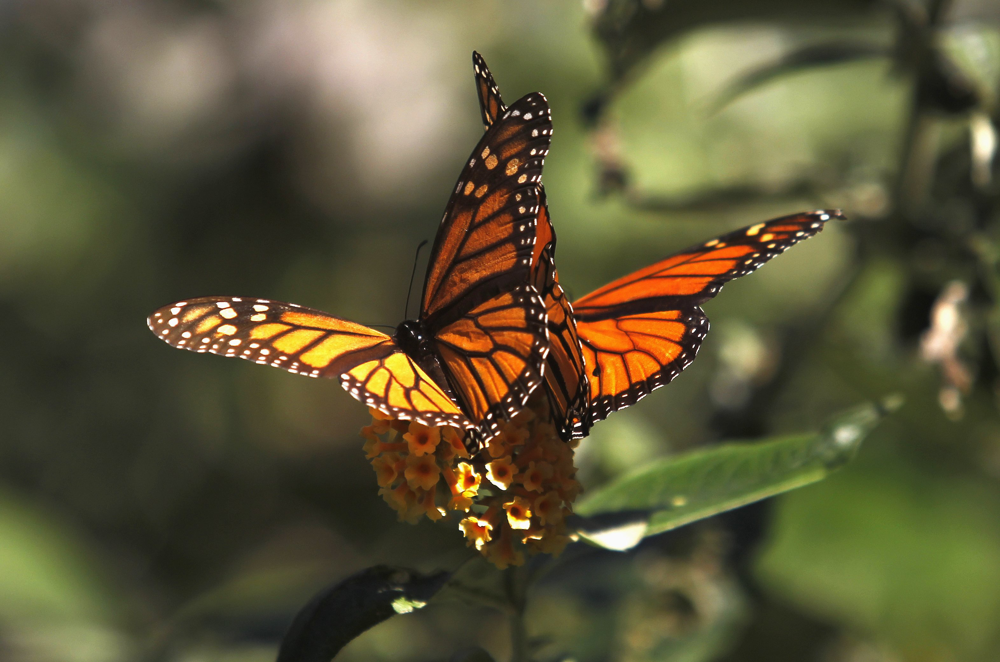

In [16]:
images_url = ['https://i.imgur.com/WCBG6Wy.jpg', \
              'https://i.imgur.com/hF1JD6G.jpg', \
              'https://i.imgur.com/xrGQW9z.jpg', \
              'https://i.imgur.com/5lGatz3.jpg', \
              'https://i.imgur.com/SERfNYh.jpg', \
              'https://i.imgur.com/sZ3baQf.jpg', \
              'https://i.imgur.com/KTOqSWg.jpg', \
              'https://i.imgur.com/4wiqps3.jpg']

from urllib.request import urlopen
from PIL import Image
import numpy as np

def get_img(url):
    img = Image.open(urlopen(url))
    print(f'initial size img.size={img.size}')
    
    if img.size[0]>1000: #if it is too large resize to a width of 1000
        resize_size = (1000,int(img.size[1]*1000/img.size[0]))
        img = img.resize(resize_size)
    print(f'after resize img.size={img.size}')
    return img
images = [get_img(url) for url in images_url]
images[0]

## Step 1: Preparing the data

The orignal images are really large so we will split them up in to small patches with a set height and width as follows;

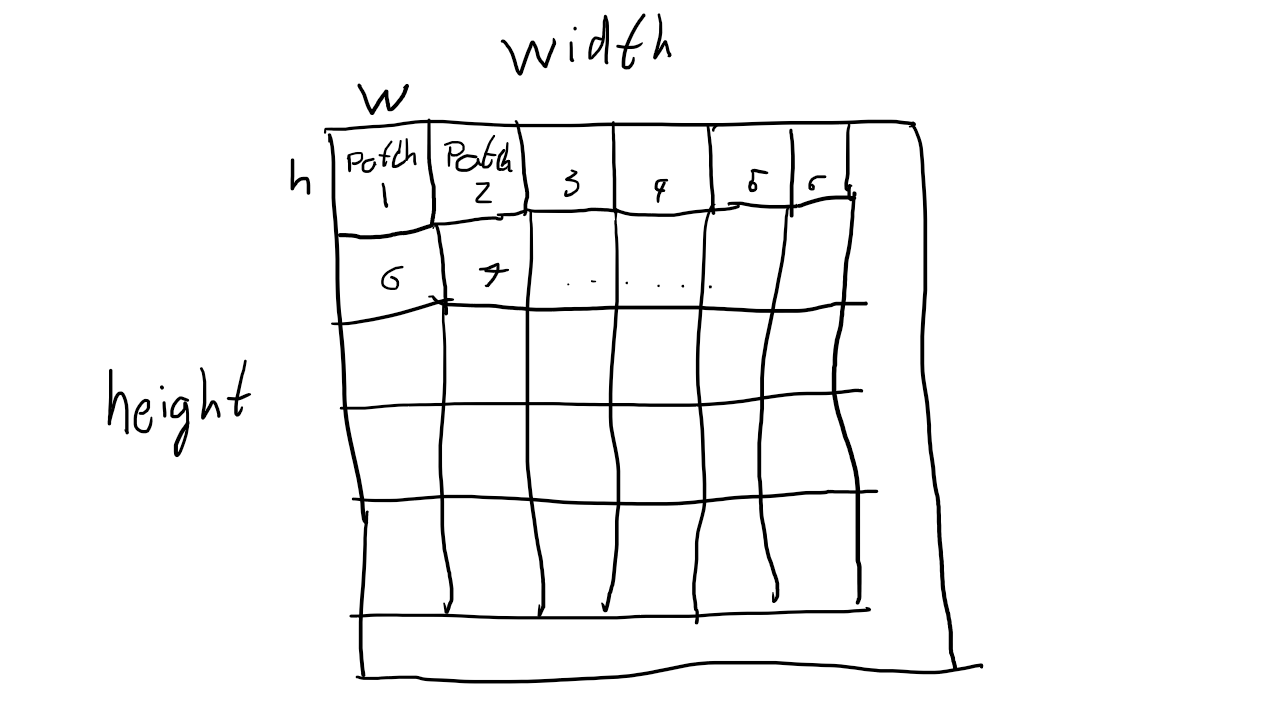

For each patch we will downsample the image by a factor of `upscale_factor_target=4` which will serve as the input for the CNN  $X$ and use the original size patches as $Y$ examples. The elements of $X$ are a whole factor of the patch size smaller than the elements of $Y$. 

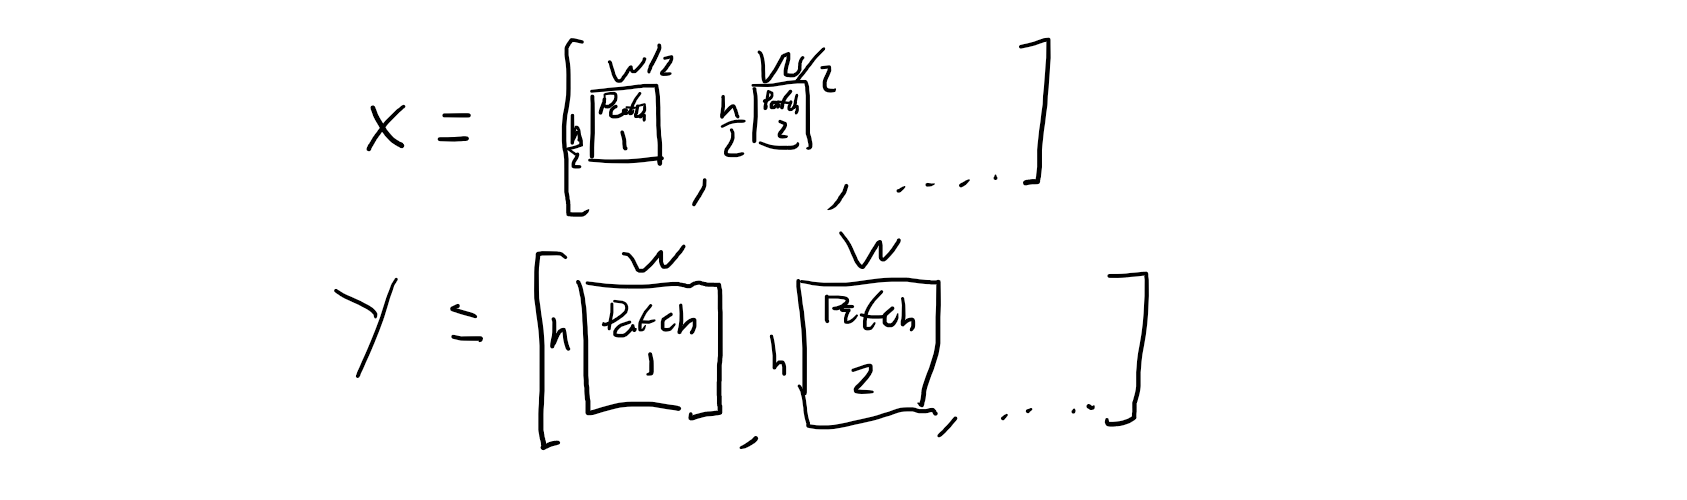

Lastly we need to split the data in a training and testing datasets. 

In [17]:
def makeXYpatches(image, patch_size = 40, upscale_factor_target = 4):
    assert patch_size%upscale_factor_target==0, 'the patch_size should be divisible by the upscale factor for the best effect'
    X,Y = [], []
    width, height = image.size
    for x in range(0,width//patch_size):
        for y in range(0,height//patch_size):
            left = x*patch_size
            right = left+patch_size
            upper = y*patch_size
            lower = upper + patch_size
            
            patch = image.crop(box=(left,upper,right,lower))
            patch_small = patch.resize((patch_size//upscale_factor_target,patch_size//upscale_factor_target))
            
            X.append(np.array(patch_small))
            Y.append(np.array(patch))
    return X,Y

def get_train_test_data(images,upscale_factor_target = 4, patch_size = 40):
    X, Y = [], []
    for image in images:
        Xnew, Ynew = makeXYpatches(image, patch_size=patch_size, upscale_factor_target=upscale_factor_target)
        X.extend(Xnew)
        Y.extend(Ynew)
    X = np.moveaxis(np.array(X),3,1)
    Y = np.moveaxis(np.array(Y),3,1)
    print(f'X.shape={X.shape}')
    print(f'Y.shape={Y.shape}')

    import sklearn.model_selection
    import torch
    convert = lambda a: [torch.as_tensor(ai,dtype=torch.float32)/255 for ai in a] #rescale for 0 to 1
    return convert(sklearn.model_selection.train_test_split(X,Y))



upscale_factor_target = 4
patch_size = 40
X_train, X_test, Y_train, Y_test = get_train_test_data(images, \
                    upscale_factor_target=upscale_factor_target, patch_size=patch_size)
print(X_train.shape) #shape = (Nsamples, )

X.shape=(2791, 3, 10, 10)
Y.shape=(2791, 3, 40, 40)
torch.Size([2093, 3, 10, 10])


### Step 2: Obtain baseline models

For super resolution there are multiple classical algorithm available

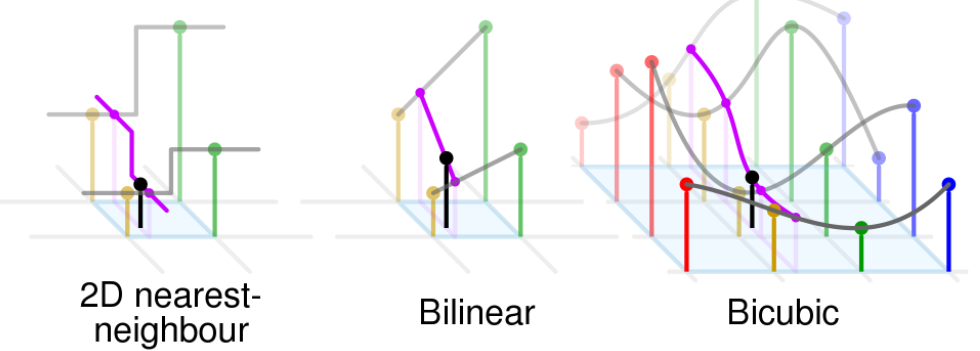

 * https://en.wikipedia.org/wiki/Nearest-neighbor_interpolation
 * https://en.wikipedia.org/wiki/Bilinear_interpolation
 * https://en.wikipedia.org/wiki/Bicubic_interpolation
 
We want to make a CNN which is able to outperform these methods for our set of images.

Below you can see that bicubic is the best method for our dataset. 

In [18]:
#base results
import torch
from torch import nn, optim
align_corners = False #if the corners are fixed or not. 
for mode in ['nearest', 'bilinear', 'bicubic']:
    upscale = nn.Upsample(size=None,scale_factor=upscale_factor_target,mode=mode, \
                          align_corners=align_corners if mode!='nearest' else None)

    base_loss = (nn.functional.mse_loss(upscale(X_test),Y_test)**0.5).item()

    print(f'mode={mode}, align_corners={align_corners}, RMS={base_loss:.4f}')
    
classical_upscale = nn.Upsample(size=None,scale_factor=upscale_factor_target,mode='bicubic',align_corners=False)

mode=nearest, align_corners=False, RMS=0.0527
mode=bilinear, align_corners=False, RMS=0.0469
mode=bicubic, align_corners=False, RMS=0.0425


### Step 3: Training CNN

Just as before we will require to train the CNN by gradient decent which can be found below. 

If you have a cuda enabled graphics card than you might want to try turning on the cuda option which can speed up the optimization. 

In [19]:
def train_cnn(cnn, X_train, Y_train, X_test, Y_test, epochs=1000, batch_size=32, cuda=True):
    optimizer = optim.Adam(cnn.parameters())
    if cuda: cnn.cuda()
    best_states = None
    from copy import deepcopy
    
    ids = np.arange(len(X_train),dtype=int)
    best = float('inf')
    for epoch in range(epochs):
        np.random.shuffle(ids) #inspace shuffle of the ids of the trainin set to select a random subset 
        for i in range(0,len(X_train),batch_size):
            ids_now = ids[i:i+batch_size] #the ids of the current batch
            x = X_train[ids_now] if not cuda else X_train[ids_now].cuda()
            y = Y_train[ids_now] if not cuda else Y_train[ids_now].cuda()

            y_p = cnn(x)
            loss = nn.functional.mse_loss(y_p,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch%50==0:
            cnn.cpu()
            with torch.no_grad():
                val_now = nn.functional.mse_loss(cnn(X_test),Y_test)**0.5
                print(f'rmse test={val_now:.5f}, epoch={epoch}',end='')
                if val_now<best:
                    best_states = deepcopy(cnn.state_dict())
                    best = val_now
                    print(' New best')
                else:
                    print('')
            if cuda: cnn.cuda()
    cnn.cpu()
    cnn.load_state_dict(best_states)
    return cnn

### CNN implementation

There are many ways to structure a super resolution CNN. One way is to 
1. Upscale using a classical method 
2. Using the output in a CNN to refine the result.

#### Linear 0 hidden CNN

Lets start with a 0 hidden layer CNN (linear model). 

In [20]:
class CNN_basic_conv(nn.Module):
    def __init__(self,scale_factor, kernel_size = 7, padding_mode = 'replicate'):
        super(CNN_basic_conv,self).__init__()
        self.upscale = nn.Upsample(size=None,scale_factor=scale_factor,mode='bicubic',align_corners=False)
        self.cnn = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=kernel_size,padding='same',padding_mode=padding_mode)
        
    def forward(self,x):
        x_up = self.upscale(x)
        return self.cnn(x_up)

cnn = CNN_basic_conv(scale_factor=upscale_factor_target)
cnn = train_cnn(cnn, X_train, Y_train, X_test, Y_test, epochs=1000, batch_size=32, cuda=True)

rmse test=0.06177, epoch=0 New best
rmse test=0.04167, epoch=50 New best
rmse test=0.04111, epoch=100 New best
rmse test=0.04086, epoch=150 New best
rmse test=0.04079, epoch=200 New best
rmse test=0.04088, epoch=250
rmse test=0.04082, epoch=300
rmse test=0.04076, epoch=350 New best
rmse test=0.04080, epoch=400
rmse test=0.04071, epoch=450 New best
rmse test=0.04073, epoch=500
rmse test=0.04079, epoch=550
rmse test=0.04082, epoch=600
rmse test=0.04073, epoch=650
rmse test=0.04071, epoch=700 New best
rmse test=0.04085, epoch=750
rmse test=0.04081, epoch=800
rmse test=0.04076, epoch=850
rmse test=0.04068, epoch=900 New best
rmse test=0.04070, epoch=950


#### tanh 1 hidden CNN

Upscale layer with a non-linear part and linear part as follows;

```
                    -> conv2d -> tanh -> conv2d \
X -> Upscale layer <                             + add -> Y
                    -> conv2d -> -------------- /
``` 

In [21]:
class CNN_1_hidden_conv(nn.Module):
    def __init__(self,scale_factor, kernel_size = 7, padding_mode = 'replicate'):
        super(CNN_1_hidden_conv,self).__init__()
        self.upscale = nn.Upsample(size=None,scale_factor=scale_factor,mode='bicubic',align_corners=False)
        self.cnn_input_to_out = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=kernel_size,padding='same',padding_mode=padding_mode)
        self.cnn_input_to_hidden = nn.Conv2d(in_channels=3,out_channels=7,kernel_size=kernel_size,padding='same',padding_mode=padding_mode)
        self.cnn_hidden_to_out = nn.Conv2d(in_channels=7,out_channels=3,kernel_size=kernel_size,padding='same',padding_mode=padding_mode)
        
    def forward(self,x):
        x_up = self.upscale(x)
        x1 = self.cnn_input_to_out(x_up)
        xh = torch.tanh(self.cnn_input_to_hidden(x_up))
        x2 = self.cnn_hidden_to_out(xh)
        return x1 + x2

cnn_hidden = CNN_1_hidden_conv(scale_factor=upscale_factor_target)
cnn_hidden = train_cnn(cnn_hidden, X_train, Y_train, X_test, Y_test, epochs=2000, batch_size=32, cuda=True)



rmse test=0.05461, epoch=0 New best
rmse test=0.04045, epoch=50 New best
rmse test=0.03989, epoch=100 New best
rmse test=0.03904, epoch=150 New best
rmse test=0.03865, epoch=200 New best
rmse test=0.03824, epoch=250 New best
rmse test=0.03838, epoch=300
rmse test=0.03793, epoch=350 New best
rmse test=0.03809, epoch=400
rmse test=0.03784, epoch=450 New best
rmse test=0.03782, epoch=500 New best
rmse test=0.03788, epoch=550
rmse test=0.03788, epoch=600
rmse test=0.03813, epoch=650
rmse test=0.03786, epoch=700
rmse test=0.03775, epoch=750 New best
rmse test=0.03794, epoch=800
rmse test=0.03822, epoch=850
rmse test=0.03838, epoch=900
rmse test=0.03764, epoch=950 New best
rmse test=0.03796, epoch=1000
rmse test=0.03774, epoch=1050
rmse test=0.03786, epoch=1100
rmse test=0.03761, epoch=1150 New best
rmse test=0.03778, epoch=1200
rmse test=0.03797, epoch=1250
rmse test=0.03763, epoch=1300
rmse test=0.04032, epoch=1350
rmse test=0.03769, epoch=1400
rmse test=0.03789, epoch=1450
rmse test=0.037

#### Conv2D + pixel_shuffle

You can also forgo the use of the classical upscale layer and replace it with a Conv2D in combination with a [pixel_shuffle](https://pytorch.org/docs/stable/generated/torch.nn.PixelShuffle.html) ([paper](https://arxiv.org/pdf/1609.05158.pdf)) to upscale the images in the first step. 

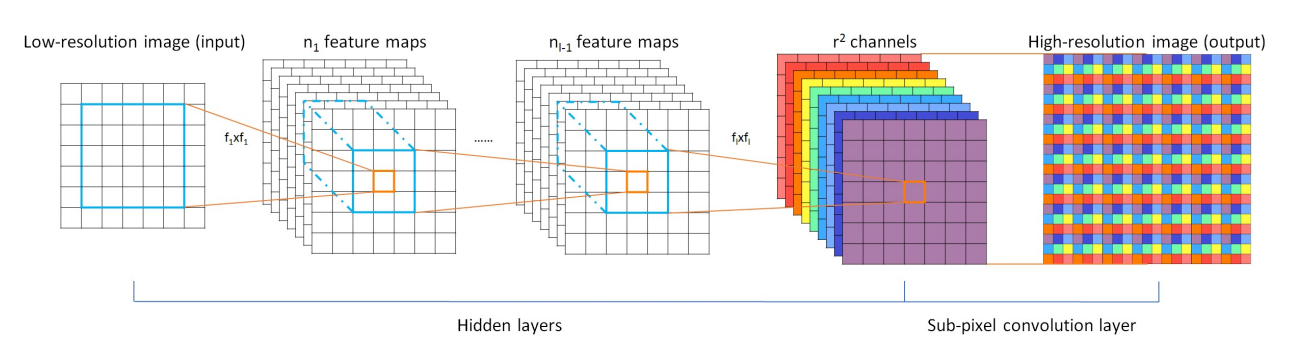

In [22]:
class ConvShuffle(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding='same', upscale_factor=2, \
        padding_mode='zeros'):
        super(ConvShuffle, self).__init__()
        self.upscale_factor = upscale_factor
        self.conv = nn.Conv2d(in_channels, out_channels*upscale_factor**2, kernel_size, padding=padding, \
            padding_mode=padding_mode)
    
    def forward(self, X):
        X = self.conv(X) #(N, Cout*upscale**2, H, W)
        return nn.functional.pixel_shuffle(X, self.upscale_factor) #(N, Cin, H*r, W*r)


class CNN_1_hidden_conv_pixel_shuffle(nn.Module):
    def __init__(self, scale_factor, kernel_size = 7, padding_mode = 'replicate'):
        super(CNN_1_hidden_conv_pixel_shuffle,self).__init__()
        self.upscale =             ConvShuffle(in_channels=3, out_channels=3, kernel_size=kernel_size, padding='same', upscale_factor=scale_factor, padding_mode=padding_mode)
        self.cnn_input_to_out =    nn.Conv2d(  in_channels=3, out_channels=3, kernel_size=kernel_size, padding='same',padding_mode=padding_mode)
        self.cnn_input_to_hidden = nn.Conv2d(  in_channels=3, out_channels=7, kernel_size=kernel_size, padding='same',padding_mode=padding_mode)
        self.cnn_hidden_to_out =   nn.Conv2d(  in_channels=7, out_channels=3, kernel_size=kernel_size, padding='same',padding_mode=padding_mode)
        
    def forward(self,x):
        x_up = self.upscale(x)
        x1 = self.cnn_input_to_out(x_up)
        xh = torch.tanh(self.cnn_input_to_hidden(x_up))
        x2 = self.cnn_hidden_to_out(xh)
        return x1 + x2

cnn_hidden_pixel = CNN_1_hidden_conv_pixel_shuffle(scale_factor=upscale_factor_target)
cnn_hidden_pixel = train_cnn(cnn_hidden_pixel, X_train, Y_train, X_test, Y_test, epochs=2000, batch_size=32, cuda=True)



rmse test=0.12051, epoch=0 New best
rmse test=0.04209, epoch=50 New best
rmse test=0.04024, epoch=100 New best
rmse test=0.03993, epoch=150 New best
rmse test=0.03956, epoch=200 New best
rmse test=0.03950, epoch=250 New best
rmse test=0.03965, epoch=300
rmse test=0.03936, epoch=350 New best
rmse test=0.03944, epoch=400
rmse test=0.03935, epoch=450 New best
rmse test=0.03945, epoch=500
rmse test=0.03885, epoch=550 New best
rmse test=0.03815, epoch=600 New best
rmse test=0.03808, epoch=650 New best
rmse test=0.03814, epoch=700
rmse test=0.03805, epoch=750 New best
rmse test=0.03784, epoch=800 New best
rmse test=0.03783, epoch=850 New best
rmse test=0.03780, epoch=900 New best
rmse test=0.03874, epoch=950
rmse test=0.03785, epoch=1000
rmse test=0.03796, epoch=1050
rmse test=0.03765, epoch=1100 New best
rmse test=0.03984, epoch=1150
rmse test=0.03736, epoch=1200 New best
rmse test=0.03781, epoch=1250
rmse test=0.03736, epoch=1300 New best
rmse test=0.03746, epoch=1350
rmse test=0.05635, ep

### Step 4: Plot Results

rmse test 0.04247 bicubic
rmse test 0.04068 cnn linear
rmse test 0.03756 cnn hidden
rmse test 0.03726 pixel shuffle


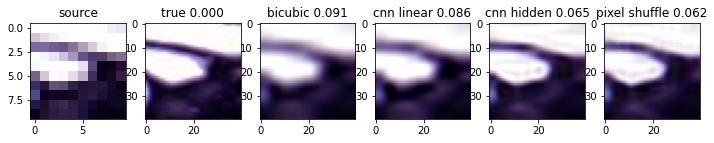

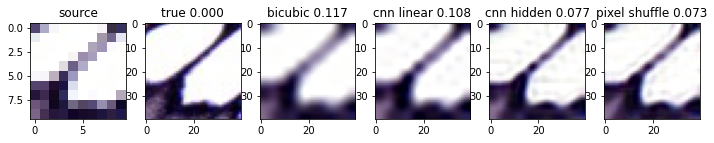

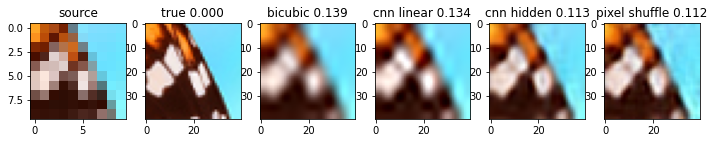

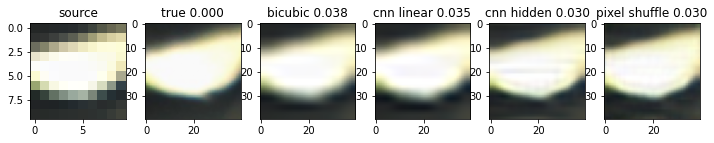

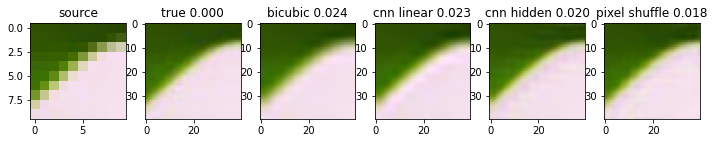

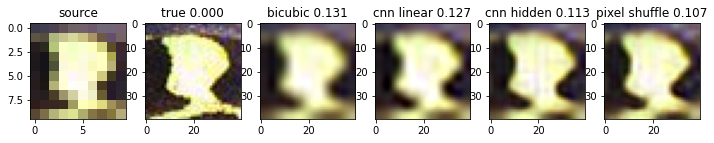

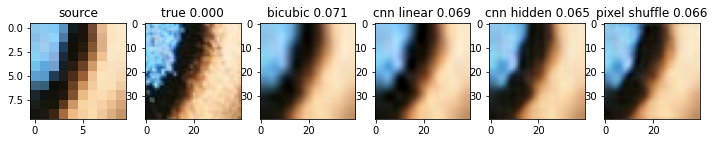

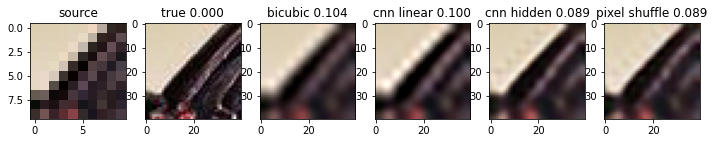

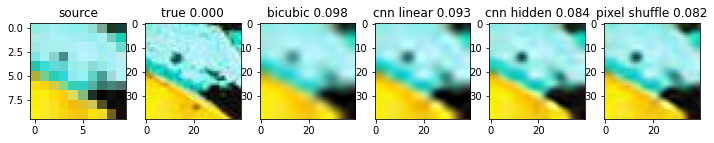

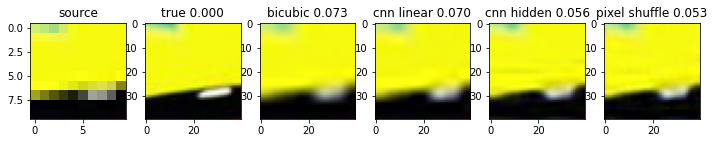

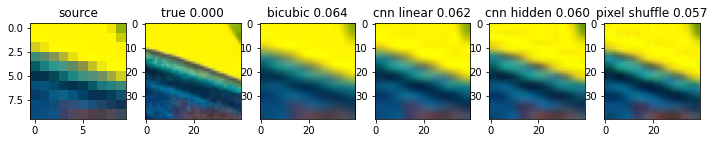

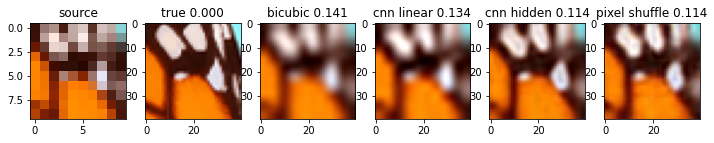

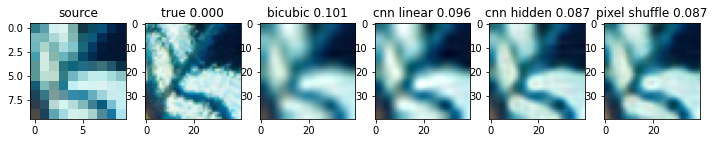

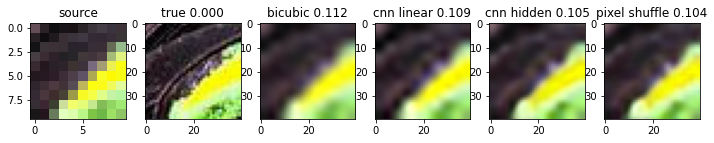

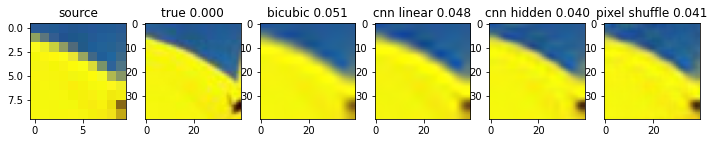

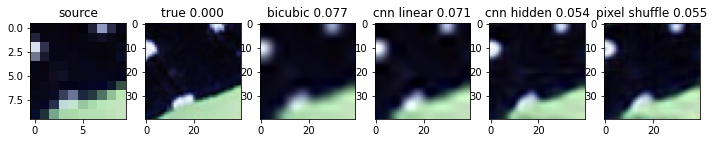

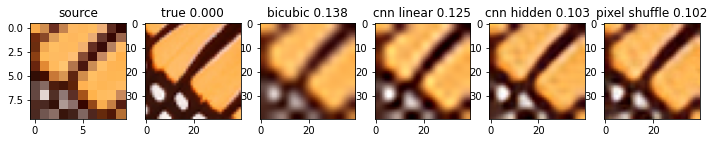

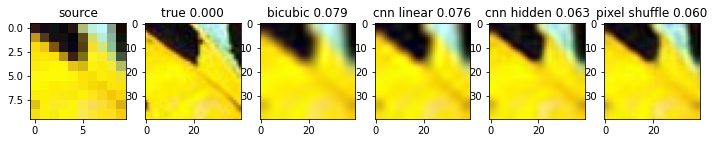

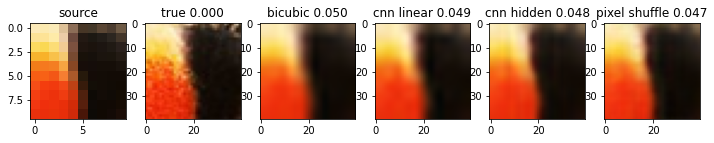

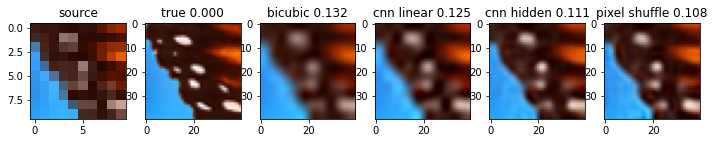

In [23]:
from matplotlib import pyplot as plt
def show_results(models, X_test, Y_test):
    with torch.no_grad():
        for name, model in models:
            val_now = nn.functional.mse_loss(model(X_test),Y_test)**0.5
            print(f'rmse test {val_now:.5f} {name}')
            
        #some complicated expression to extract the most interesting patches (the ones with the largest std)
        zlist = [z[0] for z in sorted(zip(np.arange(Y_test.shape[0]),np.mean(np.std(Y_test.numpy(),axis=(2,3)),axis=1)),key=lambda x: -x[1])[:20]]
        for z in zlist:
            Xnow, Ynow = X_test[z], Y_test[z]
            plt.figure(figsize=(2*(len(models)+2), 2))
            for i in range(-2,len(models)):
                if i==-2:
                    Yp = Xnow
                elif i==-1:
                    Yp = Ynow
                    name = 'true'
                else:
                    name, model = models[i]
                    Yp = model(Xnow[None,:,:,:])[0]

                plt.subplot(1,len(models)+2,i+3)
                if i!=-2:
                    plt.title(f'{name} {np.mean((Ynow.numpy()-Yp.numpy())**2)**0.5:.3f}')
                else:
                    plt.title(f'source')
                plt.imshow(np.moveaxis(np.clip(Yp.numpy(),0,1),0,2))
            plt.show()
show_results([('bicubic', classical_upscale), ('cnn linear', cnn), ('cnn hidden', cnn_hidden), ('pixel shuffle', cnn_hidden_pixel)], X_test, Y_test)


Currently the state-of-the-art in super-resolution uses CNN and Generative Adversarial
Network. (e.g. https://arxiv.org/pdf/1609.04802.pdf)